# Projected Points Model
* Uses fantasy football data and NFL game spreads to predict player scores on a given week
* Brock Ricker
* https://github.com/brock-ricker
* Created 07/06/2022

In [149]:
#import modules here
import pandas as pd
import numpy as np
import math
from sqlalchemy import create_engine, inspect
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [13]:
# create sqlite engine for fantasy_league db
engine = create_engine("sqlite:///fantasy_football_data.db", echo=True)
#create connection to the engine
conn = engine.connect()

In [14]:
#creating inspector
inspector = inspect(engine)

In [15]:
#using the inspector
inspector.get_table_names()

2022-07-09 12:28:02,103 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2022-07-09 12:28:02,104 INFO sqlalchemy.engine.Engine [raw sql] ()


['adp',
 'league_teams',
 'points_allowed',
 'projected_scores',
 'simple_players',
 'spreads',
 'weekly_matchup',
 'weekly_players',
 'weekly_teams']

# Data Cleaning

In [16]:
#Defining dictionairy to bin game time into categorical
time_dict = {'8:30':"night", 
'1:00':"morning", 
'4:04':"afternoon", 
'4:25':"afternoon", 
'7:10':"night", 
'10:20':"night", 
'8:24':"night", 
'9:29':"night", 
'12:30':"afternoon",
'4:30':"afternoon",
'8:20':"night",
'8:15':"night",
'7:15':"night",
'10:10':"night",
'7:05':"night",
'7:00':"night",
'5:00':"afternoon",
'3:39':"afternoon",
'8:05':"night",
'4:00':"afternoon"
}

In [17]:
#SQL query for relevant data
sql = """
SELECT wp.score AS player_score, wp.week, wp.year, wp.status, wp.regular_season, sp.name, sp.team AS player_team, sp.position, s.day, s.time, s.team, s.opp, s.spread, s.predicted_score, pa.points AS team_points_allowed, ps.projected_scores, adp.averagePick
FROM weekly_players AS wp
LEFT JOIN 
simple_players AS sp
ON wp.id = sp.id AND wp.year = sp.year
LEFT JOIN
spreads AS s
ON wp.week = s.week AND wp.year = s.year AND sp.team = s.team
LEFT JOIN
points_allowed AS pa
ON s.opp = pa.team AND s.year = pa.year AND sp.position = pa.pos
LEFT JOIN
projected_scores as ps
ON wp.id = ps.id AND wp.week = ps.week AND wp.year = ps.year
LEFT JOIN
adp
ON wp.id = adp.id AND wp.year = adp.year;
"""
df = pd.read_sql_query(sql, engine)

2022-07-09 12:28:02,186 INFO sqlalchemy.engine.Engine 
SELECT wp.score AS player_score, wp.week, wp.year, wp.status, wp.regular_season, sp.name, sp.team AS player_team, sp.position, s.day, s.time, s.team, s.opp, s.spread, s.predicted_score, pa.points AS team_points_allowed, ps.projected_scores, adp.averagePick
FROM weekly_players AS wp
LEFT JOIN 
simple_players AS sp
ON wp.id = sp.id AND wp.year = sp.year
LEFT JOIN
spreads AS s
ON wp.week = s.week AND wp.year = s.year AND sp.team = s.team
LEFT JOIN
points_allowed AS pa
ON s.opp = pa.team AND s.year = pa.year AND sp.position = pa.pos
LEFT JOIN
projected_scores as ps
ON wp.id = ps.id AND wp.week = ps.week AND wp.year = ps.year
LEFT JOIN
adp
ON wp.id = adp.id AND wp.year = adp.year;

2022-07-09 12:28:02,186 INFO sqlalchemy.engine.Engine [raw sql] ()


In [18]:
#filling in blank projected scores to 0
df["player_score"] = df["player_score"].fillna(0)
df["projected_scores"] = df["projected_scores"].fillna(0)

In [19]:
#dropping FAs
df = df[~(df["player_team"]=="FA")]
df = df[~(df["player_team"]=="FA*")]

In [20]:
df.head()

,player_score,week,year,status,regular_season,name,player_team,position,day,time,team,opp,spread,predicted_score,team_points_allowed,projected_scores,averagePick
0,16.0,1,2017,starter,1,"Goff, Jared",LAR,QB,Sun,4:04,LAR,IND,-3.5,22.5,16.27,8.59,193.63
1,13.0,1,2017,starter,1,"Newton, Cam",CAR,QB,Sun,4:25,CAR,SFO,-4.5,25.0,19.84,20.43,87.28
2,5.5,1,2017,starter,1,"Abdullah, Ameer",DET,RB,Sun,1:00,DET,ARI,2.5,23.0,19.74,11.60,62.96
3,5.5,1,2017,starter,1,"Bell, Le'Veon",PIT,RB,Sun,1:00,PIT,CLE,-10.0,28.5,21.02,21.66,2.28
4,5.5,1,2017,starter,1,"Powell, Bilal",NYJ,RB,Sun,1:00,NYJ,BUF,7.0,17.5,26.34,12.84,72.58


In [21]:
#regular season games only
df = df.loc[df["regular_season"]==1]

In [22]:
#remaining null values are from bye weeks and cancelled games, I think it is best to just drop these completely
df_clean = df.dropna()

In [23]:
#binning time slots of games to morning/afternoon/night
df_clean["time"].replace(time_dict,inplace=True)

C:\Users\brock\AppData\Local\Temp\ipykernel_32420\408429680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["time"].replace(time_dict,inplace=True)


# Data pre-processing

In [24]:
#split into features and target
X = df_clean[["week","position","day","time","spread","predicted_score","team_points_allowed","averagePick","projected_scores"]]
y = df_clean["player_score"]

In [25]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [26]:
#create column transformer - isntantiate tools for column selector here

#column selectors
num_selector = make_column_selector(dtype_include="number")
cat_selector = make_column_selector(dtype_include="object")

#instantiate encoder
ohe = OneHotEncoder(sparse="False",handle_unknown="ignore")

#instantiate scaler
scaler = StandardScaler()

In [27]:
#make column transformer, not all models will need data scaled, but it wont hurt so I will scale everything for simplicity

transformer = make_column_transformer((scaler,num_selector),(ohe,cat_selector),remainder = "passthrough")

In [28]:
#fit transformer on X_train
transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6855B5310>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse='False'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6855B5D90>)])

In [29]:
X_train_processed = transformer.transform(X_train)
X_test_processed = transformer.transform(X_test)

# Building the model

In [30]:
#Building Function to evaluate all models - this will be used later
def eval_model(true,pred):
    r2 = r2_score(true,pred)
    mae = mean_absolute_error(true,pred)
    mse = mean_squared_error(true,pred)
    rmse = np.sqrt(mse)
    print(f" R2: {r2:,.4f} \n MAE: {mae:,.2f} \n MSE: {mse:,.2f} \n RMSE: {rmse:,.2f}")

In [31]:
#instnatiate model
gbr = GradientBoostingRegressor(random_state=42,loss="squared_error")

In [32]:
#set parameters for girdSearch
gbr_params = {
    'max_depth': [1,2,3,4,5,6],
    'n_estimators': [100,200,300,400,500]
}

In [33]:
#instantiate grid
gbr_grid = GridSearchCV(gbr,gbr_params)

In [34]:
#fit grid
gbr_grid.fit(X_train_processed,y_train)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [35]:
#define model
gbr_best = gbr_grid.best_estimator_

In [37]:
#instantiate second model
#This one will minimize MAE instead of MSE, I think this makes more sense for this application, because the spread between true - predicted is what matters the most.
gbr_mae = GradientBoostingRegressor(random_state=42, loss="absolute_error")

In [38]:
#define parameters for grid
gbr_mae_params = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'n_estimators': [50,100,200,300,400,500]
}

In [39]:
#instantiate grid
gbr_mae_grid = GridSearchCV(gbr_mae,gbr_mae_params)
#fit grid
gbr_mae_grid.fit(X_train_processed,y_train)

GridSearchCV(estimator=GradientBoostingRegressor(loss='absolute_error',
                                                 random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 100, 200, 300, 400, 500]})

In [40]:
#define MAE model
gbr_mae_best = gbr_mae_grid.best_estimator_

In [43]:
#Saving the models for future use
import pickle

filename = "points_projection_model_mse.sav"
pickle.dump(gbr_best, open(filename, "wb"))

filename = "points_projection_model_mae.sav"
pickle.dump(gbr_mae, open(filename, "wb"))

# Model Evaluation

In [41]:
#evaluate MAE model
eval_model(y_test,gbr_mae_best.predict(X_test_processed))

 R2: 0.4464 
 MAE: 4.25 
 MSE: 37.97 
 RMSE: 6.16


In [42]:
#evaluate MSE model
eval_model(y_test,gbr_best.predict(X_test_processed))

 R2: 0.4682 
 MAE: 4.45 
 MSE: 36.48 
 RMSE: 6.04


In [44]:
#evaluate MSE model
eval_model(y_test,X_test["projected_scores"])

 R2: 0.4445 
 MAE: 4.45 
 MSE: 38.10 
 RMSE: 6.17


In [46]:
#build df with original feaures and add model predictions
model_df = X_test.copy()
model_df["scores"] = y_test
model_df["mse_model_predictions"] = gbr_best.predict(X_test_processed)
model_df["mae_model_predictions"] = gbr_mae_best.predict(X_test_processed)


In [53]:
#looking at model accuracy for specific positions
positions = model_df["position"].unique()
for pos in positions:
    pos_df = model_df.loc[model_df["position"]==pos]
    print(pos)
    print("---mse---")
    eval_model(pos_df["scores"],pos_df["mse_model_predictions"])
    print("---mae---")
    eval_model(pos_df["scores"],pos_df["mae_model_predictions"])
    print("----------")

QB
---mse---
 R2: 0.6162 
 MAE: 4.86 
 MSE: 44.22 
 RMSE: 6.65
---mae---
 R2: 0.6120 
 MAE: 4.65 
 MSE: 44.69 
 RMSE: 6.69
----------
WR
---mse---
 R2: 0.3123 
 MAE: 4.42 
 MSE: 35.83 
 RMSE: 5.99
---mae---
 R2: 0.2858 
 MAE: 4.20 
 MSE: 37.21 
 RMSE: 6.10
----------
RB
---mse---
 R2: 0.4185 
 MAE: 4.37 
 MSE: 36.61 
 RMSE: 6.05
---mae---
 R2: 0.3903 
 MAE: 4.17 
 MSE: 38.39 
 RMSE: 6.20
----------
TE
---mse---
 R2: 0.3094 
 MAE: 4.20 
 MSE: 29.65 
 RMSE: 5.44
---mae---
 R2: 0.2559 
 MAE: 4.10 
 MSE: 31.95 
 RMSE: 5.65
----------


In [58]:
#filter out very low scores and predicitions (these are inactive players, players who where injured early in-game or complete flukes)
model_df_filtered = model_df.loc[(model_df["scores"]>2) & (model_df["mae_model_predictions"]>2)]

In [79]:
#Position based reg plots

def pos_reg(df,model):

    #set style
    sns.set_context('talk')
    plt.style.use('seaborn-dark')
    
    #figures size
    plt.figure(figsize= (9,12))
    
    positions = df["position"].unique()
    for i, pos in enumerate(positions):
        j = i+1
        plt.subplot(2,2,j)
        plt.title(f"{pos}s")
        pos_preds = df.loc[(df["position"] == f"{pos}")]
        sns.regplot(data=pos_preds, x=f"{model}_model_predictions", y = "scores", marker=".")
        #plt.axvline(x=pos_score[attribute].median(), color="green", ls="--", label="50%")
        #plt.axvline(x=pos_score[attribute].quantile(q=0.9), color="red", ls="--", label="90%")
        #plt.legend()
        plt.xlim(0,30)
        plt.ylim(0,40)
    plt.tight_layout()
    plt.show()

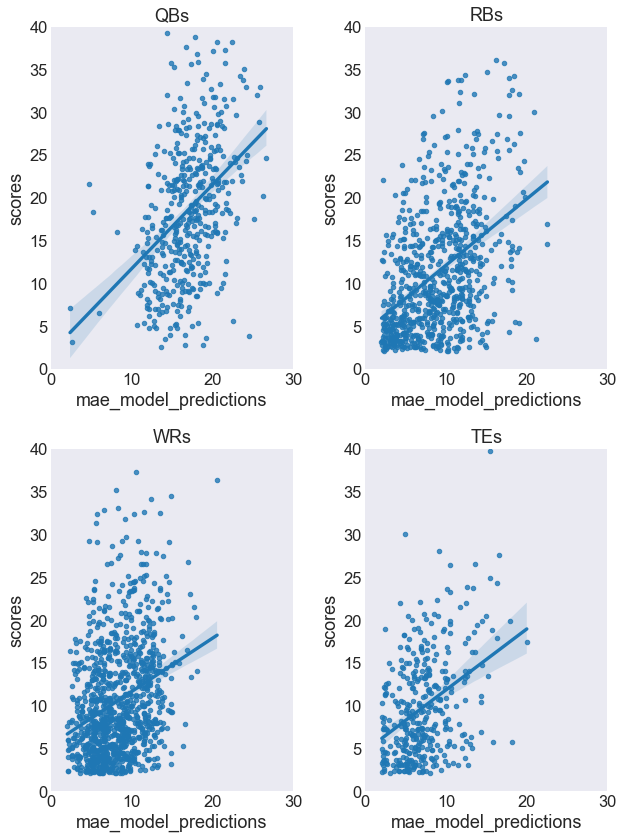

In [80]:
#positions based reg plots
pos_reg(model_df_filtered,"mae")

In [108]:
#define "good" score threshold based on exploratory analysis notebook
score_threshold_dict= {
"QB" : { "median" : 18.02 , "90th" : 28.97 },
"RB" : { "median" : 10.9 , "90th" : 23.7 },
"WR" : { "median" : 9.9 , "90th" : 21.8 },
"TE" : { "median" : 8.8 , "90th" : 20.5 }
}

In [128]:
#Position based scatter plots

def pos_scatter(df,model):

    #set style
    sns.set_context('talk')
    plt.style.use('seaborn-dark')
    
    #figures size
    plt.figure(figsize= (10,10))
    
    positions = df["position"].unique()
    for i, pos in enumerate(positions):
        j = i+1
        plt.subplot(2,2,j)
        plt.title(f"{pos}s")
        pos_preds = df.loc[(df["position"] == f"{pos}")]
        sns.scatterplot(data=pos_preds, x=f"{model}_model_predictions", y = "scores")
        plt.xlabel("Model Predicted Score")
        plt.ylabel("Score")

        #plt.axline((0,0),slope=1, color="red")
        
        plt.axvline(x=score_threshold_dict[pos]["median"], color="green", ls="--", label="50%")
        #plt.axvline(x=score_threshold_dict[pos]["90th"], color="red", ls="--", label="90%")
        plt.axhline(y=score_threshold_dict[pos]["median"], color="red", ls="--", label="50%")
        #plt.axhline(y=score_threshold_dict[pos]["90th"], color="red", ls="--", label="90%")
        
        plt.xlim(0,30)
        plt.ylim(0,40)
    plt.figlegend(["player score","predicted 'good' score", "actual 'good' score"],loc=8, ncol=3, bbox_to_anchor=[0.5, -0.05])
    plt.tight_layout()
    plt.show()

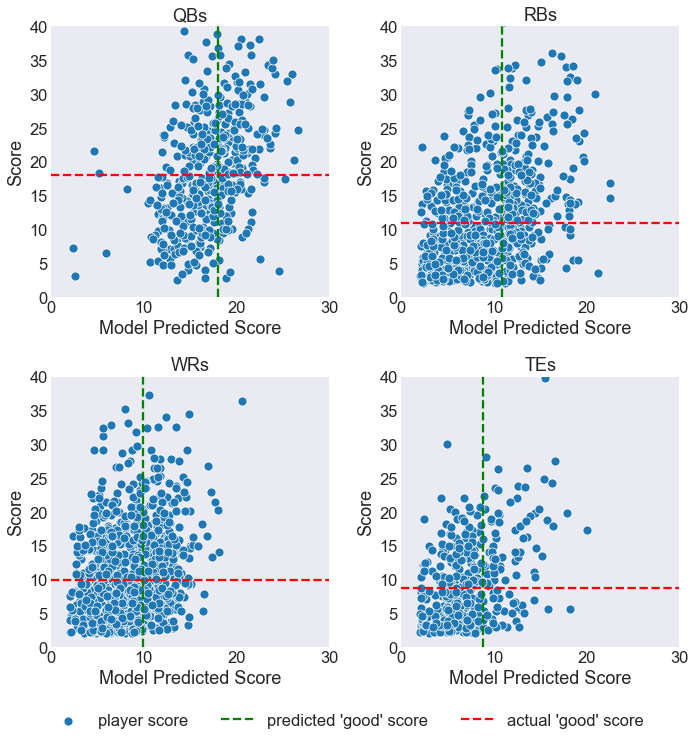

In [129]:
#position based scatter plots with score thresholds
pos_scatter(model_df_filtered,"mae")

In [157]:
#added score threshold evaluation to model df

positions = model_df_filtered["position"].unique()
score_thresholds = pd.DataFrame()

for pos in positions:
    df = model_df_filtered.loc[model_df_filtered["position"]==pos]
    df["good_score"] = score_threshold_dict[pos]["median"]
    score_thresholds = pd.concat([score_thresholds,df],ignore_index=True)

C:\Users\brock\AppData\Local\Temp\ipykernel_32420\2289195102.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["good_score"] = score_threshold_dict[pos]["median"]
C:\Users\brock\AppData\Local\Temp\ipykernel_32420\2289195102.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["good_score"] = score_threshold_dict[pos]["median"]
C:\Users\brock\AppData\Local\Temp\ipykernel_32420\2289195102.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [158]:
#adding good score/bad score
score_thresholds["good_score_model_pred"] = np.where(score_thresholds["mae_model_predictions"]>=score_thresholds["good_score"],"good_score","bad_score")
score_thresholds["good_score_result"] = np.where(score_thresholds["scores"]>=score_thresholds["good_score"],"good_score","bad_score")
score_thresholds["good_score_projection"] = np.where(score_thresholds["projected_scores"]>=score_thresholds["good_score"],"good_score","bad_score")

Model Test Metrics
              precision    recall  f1-score   support

   bad_score       0.63      0.80      0.71      1447
  good_score       0.66      0.46      0.54      1240

    accuracy                           0.64      2687
   macro avg       0.65      0.63      0.63      2687
weighted avg       0.65      0.64      0.63      2687



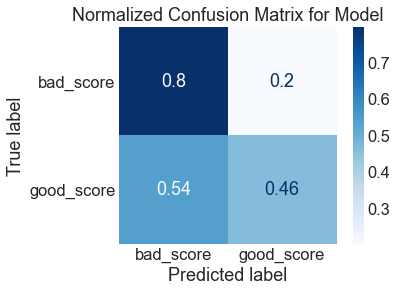

In [159]:
#printing out classification metrics

print(f"Model Test Metrics")
print(classification_report(score_thresholds["good_score_result"],score_thresholds["good_score_model_pred"],zero_division = 0))
disp1 = ConfusionMatrixDisplay.from_predictions(score_thresholds["good_score_result"],score_thresholds["good_score_model_pred"], cmap = "Blues",normalize="true");
disp1.ax_.set_title(f"Normalized Confusion Matrix for Model");

myFantasy Projections Metrics
              precision    recall  f1-score   support

   bad_score       0.64      0.65      0.65      1447
  good_score       0.59      0.58      0.58      1240

    accuracy                           0.62      2687
   macro avg       0.61      0.61      0.61      2687
weighted avg       0.62      0.62      0.62      2687



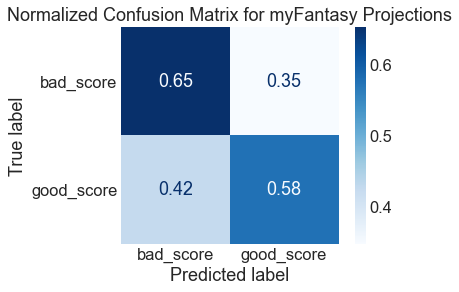

In [174]:
#printing out classification metrics

print(f"myFantasy Projections Metrics")
print(classification_report(score_thresholds["good_score_result"],score_thresholds["good_score_projection"],zero_division = 0))
disp1 = ConfusionMatrixDisplay.from_predictions(score_thresholds["good_score_result"],score_thresholds["good_score_projection"], cmap = "Blues",normalize="true");
disp1.ax_.set_title(f"Normalized Confusion Matrix for myFantasy Projections");